In [72]:
%reset -f
import gc
gc.collect()

17164

In [73]:
global z0
global w0

w0 = 4
z0 = 3

n = 27
q = 7
num_samples = 1000

num_unseen_samples= 20

In [74]:
import numpy as np
import tensorflow as tf
import math

np.random.seed(42)

In [75]:
def next_power_of_two(x):
    return 2 ** math.ceil(math.log2(x))

n_padded = next_power_of_two(n)

x_original = np.random.randint(0, q, size=(num_samples, n))

padding = n_padded - n
dataset = np.pad(x_original, ((0, 0), (0, padding)), mode='constant', constant_values=0)

print(f"Original n: {n}, Padded to: {n_padded}")

Original n: 27, Padded to: 32


In [76]:
dataset.shape

(1000, 32)

In [77]:
from sklearn.model_selection import train_test_split

y_train, y_val = train_test_split(
    dataset,
    test_size=0.2,
    shuffle=True,
    random_state=42
)

In [78]:
print(y_train.shape)
print(y_val.shape)

(800, 32)
(200, 32)


In [79]:
print(y_train)

[[1 1 2 ... 0 0 0]
 [5 3 6 ... 0 0 0]
 [1 4 3 ... 0 0 0]
 ...
 [3 6 5 ... 0 0 0]
 [1 5 1 ... 0 0 0]
 [3 3 6 ... 0 0 0]]


In [80]:
print(y_val)

[[5 6 5 ... 0 0 0]
 [1 4 1 ... 0 0 0]
 [2 6 0 ... 0 0 0]
 ...
 [6 4 3 ... 0 0 0]
 [2 3 4 ... 0 0 0]
 [4 3 6 ... 0 0 0]]


Encode using generator matrix
$$
\tilde{M}_{kj} = \left[ \left( \frac{w_0}{z_0} \right)^j \zeta^{kj} \right]_{k,j=0}^{n-1}
$$

In [81]:
def padded_generator_matrix(N, w0, z0):
    n = np.arange(N)
    k = n.reshape((N, 1))
    zeta = np.exp(-2j * np.pi / N)
    M_tilde = ((w0 / z0) ** n) * (zeta ** (k * n))
    return M_tilde

In [82]:
M_tilde = padded_generator_matrix(n_padded, w0, z0)
print(M_tilde.shape)

(32, 32)


DCT-III Structured imposed layers

In [83]:
class FirstLayer(tf.keras.layers.Layer):
    def __init__(self, units, trainable=True, **kwargs):
        super(FirstLayer, self).__init__(**kwargs)
        self.n = units
        self.n1 = units // 2
        self.trainable = trainable

        init_diag = tf.ones(self.n1, dtype=tf.float32)
        init_diag = tf.tensor_scatter_nd_update(init_diag, [[0]], [tf.sqrt(2.0)])

        self.B_1 = self.add_weight(
                shape=(self.n1,),
                initializer=tf.keras.initializers.Constant(init_diag),
                trainable=self.trainable,
                name='B_1'
            )
        self.B_2 = self.add_weight(
                shape=(self.n1,),
                initializer='ones',
                trainable=self.trainable,
                name='B_2'
            )
        self.bias = self.add_weight(
            shape=(self.n,),
            initializer='zeros',
            trainable=True,
            name='bias'
        )

    def call(self, x):
        even = x[:, ::2]
        odd = x[:, 1::2]

        d1 = tf.multiply(odd, self.B_1) # diagonal
        d2 = tf.multiply(tf.concat([tf.zeros_like(odd[:, :1]), odd[:, :-1]], axis=1), self.B_2) # off-diagonal
        B_n = tf.add(d1, d2)

        u = tf.concat([even, B_n], axis=1)

        return u + self.bias

In [84]:
class DCTIII(tf.keras.layers.Layer):
    def __init__(self, n, trainable=True, **kwargs):
        super(DCTIII, self).__init__(**kwargs)
        self.n = n
        self.n1 = n // 2 if n > 2 else 1
        self.trainable = trainable

        if n == 2:
            # Base case: trainable 2x2 matrix
            self.C_2 = self.add_weight(
                shape=(2, 2),
                initializer=tf.keras.initializers.Constant((1 / np.sqrt(2)) * np.array([[1., 1.], [1., -1.]])),
                trainable=self.trainable,
                name='C_2'
            )
        else:
            init_diag = tf.ones(self.n1, dtype=tf.float32)
            init_diag = tf.tensor_scatter_nd_update(init_diag, [[0]], [tf.sqrt(2.0)])

            # Weights for B^T_{n/2}
            self.B_1 = self.add_weight(
                shape=(self.n1,),
                initializer=tf.keras.initializers.Constant(init_diag),
                trainable=self.trainable,
                name='B_1'
            )
            self.B_2 = self.add_weight(
                shape=(self.n1,),
                initializer='ones',
                trainable=self.trainable,
                name='B_2'
            )

            k = tf.cast(tf.range(1, self.n1 + 1), tf.float32)
            pi = tf.constant(np.pi, dtype=tf.float32)
            init_W_c = 1 / (2 * tf.cos((2 * k - 1) * (pi / (2 * self.n))))

            # Weight for W_c
            self.w_c = self.add_weight(
                shape=(self.n1,),
                initializer=tf.keras.initializers.Constant(init_W_c),
                trainable=self.trainable,
                name='W_c'
            )
            # Recursive DCTIII for n/2
            self.dctiii_layer1 = DCTIII(self.n1,trainable=self.trainable)
            self.dctiii_layer2 = DCTIII(self.n1,trainable=self.trainable)

    def call(self, x):
        if self.n == 2:
            y = tf.matmul(self.C_2, x, transpose_b=True)
            return tf.transpose(y)
        else:
            # Permutation
            even = x[:, ::2]
            odd = x[:, 1::2]

            # B^T
            d1 = tf.multiply(odd, self.B_1)
            d2 = tf.multiply(tf.concat([tf.zeros_like(odd[:, :1]), odd[:, :-1]], axis=1), self.B_2)
            B_n = tf.add(d1, d2)
            u = tf.concat([even, B_n], axis=1)

            # Recursive DCTIII
            z1 = self.dctiii_layer1(u[:, :self.n1])
            z2 = self.dctiii_layer2(u[:, self.n1:])
            recurs_out = tf.concat([z1, z2], axis=1)

            # W_c
            W_n = tf.multiply(recurs_out[:, self.n1:], self.w_c)
            v = tf.concat([recurs_out[:, :self.n1], W_n], axis=1)

            # H_n
            out1 = v[:, :self.n1]
            out2 = v[:, self.n1:]
            y = (1 / tf.sqrt(tf.constant(2.0, dtype=tf.float32))) * tf.concat(
                [(out1 + out2), tf.reverse((out1 - out2), axis=[1])],
                axis=1
            )

            return y

In [85]:
class SecondLayer(tf.keras.layers.Layer):
    def __init__(self, units, trainable=True, **kwargs):
        super(SecondLayer, self).__init__(**kwargs)
        self.n = units
        self.n1 = units // 2
        self.trainable = trainable

        self.bias = self.add_weight(
            shape=(self.n,),
            initializer='zeros',
            trainable=True,
            name='bias'
        )

        self.dctiii1 = DCTIII(self.n1, trainable=self.trainable)
        self.dctiii2 = DCTIII(self.n1,trainable=self.trainable)

    def call(self, x):
        z1 = self.dctiii1(x[:, :self.n1])
        z2 = self.dctiii2(x[:, self.n1:])
        out = tf.concat([z1, z2], axis=1)
        return out + self.bias

In [86]:
class ThirdLayer(tf.keras.layers.Layer):
    def __init__(self, units, trainable=True, **kwargs):
        super(ThirdLayer, self).__init__(**kwargs)
        self.n = units
        self.n1 = units // 2
        self.trainable = trainable

        k = tf.cast(tf.range(1, self.n1 + 1), tf.float32)
        pi = tf.constant(np.pi, dtype=tf.float32)
        init_W_c = 1 / (2 * tf.cos((2 * k - 1) * (pi / (2 * self.n))))

        self.w_c = self.add_weight(
                shape=(self.n1,),
                initializer=tf.keras.initializers.Constant(init_W_c),
                trainable=self.trainable,
                name='W_c'
            )

        self.bias = self.add_weight(
            shape=(self.n,),
            initializer='zeros',
            trainable=True,
            name='bias'
        )

    def call(self, x):
        input1 = x[:, :self.n1]
        input2 = x[:, self.n1:]

        # W_{N/2}
        W_n = tf.multiply(input2, self.w_c)
        v = tf.concat([input1, W_n], axis=1)

        # H_n^T
        out1 = v[:, :self.n1]
        out2 = v[:, self.n1:]

        y = (1 / tf.sqrt(tf.constant(2.0, dtype=tf.float32))) * tf.concat([(out1 + out2), tf.reverse((out1 - out2), axis=[1])], axis=1)

        # y = self.h * tf.concat([(out1 + out2), tf.reverse((out1 - out2), axis=[1])], axis=1)

        return y + self.bias

In [87]:
class DiagonalLayer(tf.keras.layers.Layer):
    def __init__(self, units, trainable=True, kernel_initializer='he_normal', bias_initializer='zeros', **kwargs):
        super(DiagonalLayer, self).__init__(**kwargs)
        self.units = units
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.trainable = trainable

    def build(self, input_shape):
        self.diag = self.add_weight(
            shape=(self.units,),
            initializer=tf.keras.initializers.get(self.kernel_initializer),
            trainable=self.trainable,
            name='diag'
        )
        self.bias = self.add_weight(
            shape=(self.units,),
            initializer=tf.keras.initializers.get(self.bias_initializer),
            trainable=self.trainable,
            name='bias'
        )

    def call(self, inputs):
        scaled = tf.multiply(inputs, self.diag)
        return scaled + self.bias

In [88]:
class ScalingLayer(tf.keras.layers.Layer):
    def __init__(self, units, initial_scale=1.0, trainable=True, kernel_initializer='he_normal', bias_initializer='zeros', **kwargs):
        super(ScalingLayer, self).__init__(**kwargs)
        self.units = units
        self.initial_scale = initial_scale
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer

    def build(self, input_shape):

      self.log_scale = self.add_weight(
          shape=(),
          initializer=tf.keras.initializers.Constant(self.initial_scale),
          trainable=True,
          name="log_scale",
      )
      self.diag = self.add_weight(
          shape=(self.units,),
          initializer=tf.keras.initializers.get(self.kernel_initializer),
          regularizer=tf.keras.regularizers.l2(1e-4),
          trainable=True,
          name='diag'
      )
      self.bias = self.add_weight(
          shape=(self.units,),
          initializer=tf.keras.initializers.get(self.bias_initializer),
          trainable=True,
          name='bias'
        )

      super().build(input_shape)

    def call(self, inputs):
      perm = tf.concat([inputs[:, ::2], inputs[:, 1::2][:, ::-1]], axis=-1)

      dim = tf.shape(perm)[1]

      D_hat_n = tf.exp(self.log_scale * tf.cast(tf.range(dim), tf.float32))

      scaled = perm * D_hat_n * self.diag

      return scaled + self.bias

In [89]:
def custom_accuracy(y_true, y_pred):
    y_true_int = tf.cast(y_true * (q - 1), tf.int32)  # Rescale from [0,1] to [0, q-1]
    y_pred_int = tf.cast(tf.round(y_pred * (q - 1)), tf.int32)
    mask = tf.concat(
        [tf.ones((tf.shape(y_true)[0], n), dtype=tf.float32),
         tf.zeros((tf.shape(y_true)[0], n_padded - n), dtype=tf.float32)],
        axis=1
    )
    correct = tf.cast(tf.equal(y_true_int, y_pred_int), tf.float32) * mask
    return tf.reduce_sum(correct) / tf.reduce_sum(mask)

def custom_mse(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    loss = tf.reduce_mean(tf.square(tf.cast(y_true - y_pred, tf.float32)))
    return loss

In [90]:
from tensorflow.keras.layers import InputLayer, LeakyReLU, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

initial_log_scale = np.log(z0 / w0)
initial_scale = (z0 / w0)

input_shape = (n_padded,)
model = Sequential([
    InputLayer(shape=input_shape),
    FirstLayer(units=n_padded, trainable=True, name="first_layer"),
    # Activation('linear'),
    SecondLayer(units=n_padded, trainable=True, name="second_layer"),
    # Activation('linear'),
    ThirdLayer(units=n_padded, trainable=True, name="third_layer"),
    LeakyReLU(negative_slope=0.1),
    ScalingLayer(units=n_padded, initial_scale=initial_log_scale, kernel_initializer='ones', bias_initializer='zeros', name="scaling_layer"),
    LeakyReLU(negative_slope=0.1),
    DiagonalLayer(units=n_padded, trainable=False, kernel_initializer='ones', bias_initializer='zeros', name="output_layer"),
    Activation('linear')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mse', custom_accuracy]
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ first_layer (FirstLayer)        │ (None, 32)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ second_layer (SecondLayer)      │ (None, 32)             │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ third_layer (ThirdLayer)        │ (None, 32)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ scaling_layer (ScalingLayer)    │ (None, 32)             │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (DiagonalLayer)    │ (None, 32)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 481 (1.88 KB)

 Trainable params: 417 (1.63 KB)

 Non-trainable params: 64 (256.00 B)

Create Batches with random noise injected

In [91]:
def batch_generator(train_dataset, M_tilde, q, batch_size):
    n = train_dataset.shape[1]
    k = np.arange(n)
    alpha_k = np.where(k == 0, np.sqrt(1/n), np.sqrt(2/n))
    shift = np.exp(-1j * np.pi * k / (2 * n))

    # indices = np.arange(len(train_dataset))
    # i = 0

    while True:
        # if i + batch_size > len(train_dataset):
            # np.random.shuffle(indices)  # Shuffle for next epoch
            # i = 0

        # idx = indices[i:i+batch_size]
        # i += batch_size

        # x_batch = train_dataset[idx]

        idx = np.random.choice(len(train_dataset), size=batch_size)
        x_batch = train_dataset[idx]

        # y = Mx ---> shape: (batch_size, n)
        y_batch = np.dot(M_tilde, x_batch.T).T

        # add noise to simulate a noisy channel
        sigma_batch = np.random.uniform(0.04, 0.06)
        noise = np.random.normal(0, sigma_batch, y_batch.shape)
        y_noisy = y_batch + noise

        # convert to DCT-II coefficients
        dct2_batch = np.real(alpha_k * shift * y_noisy)
        dct2_batch = np.round(dct2_batch, decimals=10)

        # normalize
        dct2_batch = (dct2_batch - dct2_batch.mean()) / dct2_batch.std()
        y_scaled = x_batch / (q - 1)

        yield dct2_batch.astype(np.float32), y_scaled.astype(np.float32)

In [92]:
# preparing the validation data

val_encoded = np.dot(M_tilde, y_val.T).T

k = np.arange(n_padded)
alpha_k = np.where(k == 0, np.sqrt(1/n_padded), np.sqrt(2/n_padded))
shift = np.exp(-1j * np.pi * k / (2 * n_padded))
X_val_dct2 = np.real(alpha_k * shift * val_encoded)
X_val_dct2 = (X_val_dct2 - X_val_dct2.mean()) / X_val_dct2.std()

y_val_labels = y_val / (q - 1)

X_val_dct2 = X_val_dct2.astype(np.float32)
y_val_labels = y_val_labels.astype(np.float32)

In [93]:
# y_train
# y_val
# y_val_labels
# X_val_dct2

Train NN (under 5% noise)

In [94]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

adjust_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

history = model.fit(
    batch_generator(y_train, M_tilde, q=q, batch_size=64),
    steps_per_epoch=100,
    epochs=200,
    validation_data=(X_val_dct2, y_val_labels),
    callbacks=[adjust_lr, early_stopping]
)

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - custom_accuracy: 0.1416 - loss: 0.2577 - mse: 0.2546 - val_custom_accuracy: 0.1488 - val_loss: 0.1646 - val_mse: 0.1612 - learning_rate: 0.0010
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - custom_accuracy: 0.1551 - loss: 0.1364 - mse: 0.1329 - val_custom_accuracy: 0.1944 - val_loss: 0.0694 - val_mse: 0.0657 - learning_rate: 0.0010
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - custom_accuracy: 0.2279 - loss: 0.0677 - mse: 0.0640 - val_custom_accuracy: 0.2606 - val_loss: 0.0649 - val_mse: 0.0612 - learning_rate: 0.0010
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - custom_accuracy: 0.2774 - loss: 0.0638 - mse: 0.0601 - val_custom_accuracy: 0.2902 - val_loss: 0.0621 - val_mse: 0.0584 - learning_rate: 0.0010
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - custom_accuracy: 0.3045 - loss: 0.0610 - mse: 0.0573 - val_custom_accuracy: 0.3206 - val_loss: 0.0595 - val_mse: 0.0558 - learning_rate: 0.0010

In [95]:
# Evaluate the model on the test set
eval_results = model.evaluate(X_val_dct2, y_val_labels)
print(f"Test results - Loss: {eval_results[0]}, MSE: {eval_results[1]}, Accuracy: {eval_results[2]}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - custom_accuracy: 0.7691 - loss: 0.0231 - mse: 0.0209 
Test results - Loss: 0.023422034457325935, MSE: 0.02120308391749859, Accuracy: 0.7663689851760864


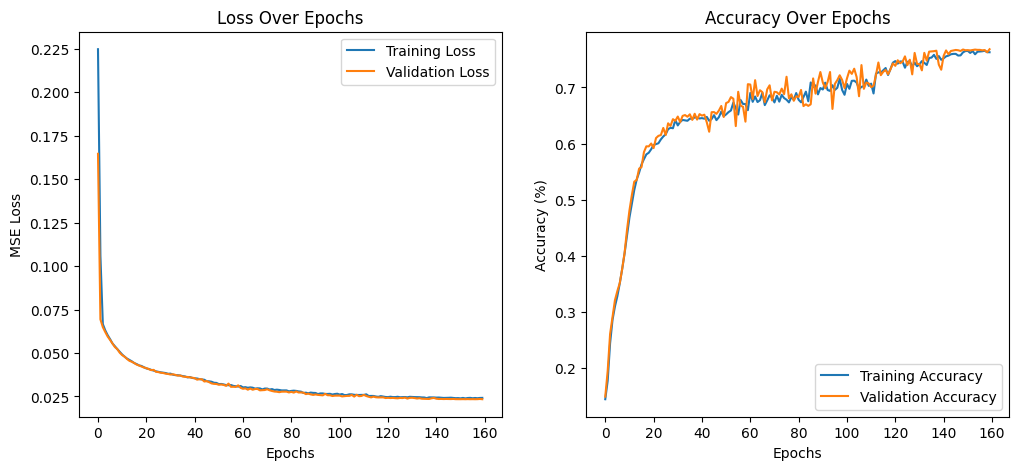

In [96]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['custom_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_custom_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

In [97]:
y_pred = model.predict(X_val_dct2)
y_pred_rescaled = y_pred * (q - 1)

print("Comparison of predictions and ground truth:")
for i in range(3):
    print(f"Sample {i+1}:")
    print(f"  Predicted:    {np.round(y_pred_rescaled[i]).astype(int)}")
    print(f"  Ground Truth: {y_val[i].astype(int)}")
    print("-" * 40)

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 209ms/step
Comparison of predictions and ground truth:
Sample 1:
  Predicted:    [3 3 3 3 3 3 2 2 6 2 3 1 4 0 3 2 5 1 4 3 4 4 6 5 2 3 1 0 0 0 0 0]
  Ground Truth: [5 6 5 1 3 4 1 1 6 2 3 1 4 0 3 2 5 1 4 3 4 4 6 5 2 3 1 0 0 0 0 0]
----------------------------------------
Sample 2:
  Predicted:    [3 3 3 3 3 3 2 5 5 2 4 3 3 1 3 1 1 2 0 1 1 5 2 1 4 0 4 0 0 0 0 0]
  Ground Truth: [1 4 1 3 3 3 0 5 5 2 4 3 3 1 3 1 1 2 0 1 1 5 2 1 4 0 4 0 0 0 0 0]
----------------------------------------
Sample 3:
  Predicted:    [3 3 3 3 3 3 3 4 2 6 4 1 0 5 2 3 5 1 4 6 0 4 3 2 3 4 4 0 0 0 0 0]
  Ground Truth: [2 6 0 2 2 1 3 4 2 6 4 1 0 5 2 3 5 1 4 6 0 4 3 2 3 4 4 0 0 0 0 0]
----------------------------------------


In [98]:
from sklearn.metrics import r2_score

r2 = r2_score(y_val_labels, y_pred)

print(f"R² Score: {r2:.4f}")

R² Score: 0.6838


In [99]:
# ---------------------- Inference time on Test Set ----------------------------

import time

_ = model.predict(X_val_dct2, verbose=0)  # warm up

times = []
for _ in range(100):
    start = time.perf_counter()
    _ = model.predict(X_val_dct2, verbose=0)
    end = time.perf_counter()
    times.append(end - start)

average_inference_time = np.mean(times)
print(f"Average batch inference time over 100 runs: {average_inference_time:.6f} seconds")

average_per_sample = average_inference_time / X_val_dct2.shape[0]
print(f"Average inference time per sample (from batch): {average_per_sample:.6f} seconds")

Average batch inference time over 100 runs: 0.123209 seconds
Average inference time per sample (from batch): 0.000616 seconds


Test on Unseen Samples

In [100]:
# --------------------- Predictions on unseen samples (no noise) -------------------------

np.random.seed(42)

x_unseen_original = np.random.randint(0, q, size=(num_unseen_samples, n))
x_unseen_original_padded = np.pad(x_unseen_original, ((0, 0), (0, padding)), mode='constant', constant_values=0)

# encode
encoded_dataset_unseen = np.array([np.dot(M_tilde, x) for x in x_unseen_original_padded])
encoded_dataset_unseen[np.abs(encoded_dataset_unseen) < 1e-10] = 0
encoded_dataset_unseen = np.round(encoded_dataset_unseen, decimals=10)

# pre-process
N = encoded_dataset_unseen.shape[1]
k = np.arange(N)
shift = np.exp(-1j * np.pi * k / (2 * N))
alpha_k = np.where(k == 0, np.sqrt(1/N), np.sqrt(2/N))

x_unseen_dct2 = np.array([np.real(alpha_k * shift * y) for y in encoded_dataset_unseen])
x_unseen_dct2[np.abs(x_unseen_dct2) < 1e-10] = 0
x_unseen_dct2 = np.round(x_unseen_dct2, decimals=10)

# Normalize
x_unseen_dct2_normalized = (x_unseen_dct2 - x_unseen_dct2.mean()) / x_unseen_dct2.std()

# Predict
nn_pred = model.predict(x_unseen_dct2_normalized)

# Rescale prediction
y_pred_final = np.mod(np.round(nn_pred * (q - 1)), q)

# Evaluate
x_unseen_original_padded_normalized = x_unseen_original_padded.astype(np.float32) / (q - 1)

mse_nn = custom_mse(x_unseen_original_padded_normalized, nn_pred)
acc_nn = custom_accuracy(x_unseen_original_padded_normalized, nn_pred)

print(f"MSE on unseen data (no noise): {mse_nn}")
print(f"Accuracy on unseen data (no noise): {acc_nn}")

num_display_samples = 3
for i in range(num_display_samples):
    print(f"\nSample {i+1}:")
    print(f"Original : {x_unseen_original_padded[i]}")
    print(f"NN Pred  : {y_pred_final[i].astype(int)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
MSE on unseen data (no noise): 0.022840730845928192
Accuracy on unseen data (no noise): 0.7740740776062012

Sample 1:
Original : [6 3 4 6 2 4 4 6 1 2 6 2 2 4 3 2 5 4 1 3 5 5 1 3 4 0 3 0 0 0 0 0]
NN Pred  : [3 3 3 3 3 3 4 5 1 2 6 2 2 4 3 2 5 4 1 3 5 5 1 3 4 0 3 0 0 0 0 0]

Sample 2:
Original : [1 5 4 3 0 0 2 2 6 1 3 3 6 5 5 6 5 2 3 6 3 0 2 4 2 6 4 0 0 0 0 0]
NN Pred  : [3 3 3 3 3 2 3 2 6 1 3 3 6 5 5 6 5 2 3 6 3 0 2 4 2 6 4 0 0 0 0 0]

Sample 3:
Original : [0 6 1 3 0 3 5 1 1 0 1 4 1 3 3 6 3 6 3 4 6 2 5 0 3 1 3 0 0 0 0 0]
NN Pred  : [3 3 3 3 3 3 4 2 1 0 1 4 1 3 3 6 3 6 3 4 6 2 5 0 3 1 3 0 0 0 0 0]


In [101]:
# --------------------- Predictions on unseen samples (with gaussian noise) -------------------------

np.random.seed(42)

x_unseen_original = np.random.randint(0, q, size=(num_unseen_samples, n))
x_unseen_original_padded = np.pad(x_unseen_original, ((0, 0), (0, padding)), mode='constant', constant_values=0)

# Encode
encoded_dataset_unseen = np.array([np.dot(M_tilde, x) for x in x_unseen_original_padded])
encoded_dataset_unseen[np.abs(encoded_dataset_unseen) < 1e-10] = 0
encoded_dataset_unseen = np.round(encoded_dataset_unseen, decimals=10)

# -------------------- Add noise ---------------------
noise_ratio = 0.02 # 2% noise

real_parts = np.real(encoded_dataset_unseen)
imag_parts = np.imag(encoded_dataset_unseen)

noise_std_real = np.abs(real_parts) * noise_ratio
noise_std_imag = np.abs(imag_parts) * noise_ratio

noise_real = np.random.normal(0, noise_std_real)
noise_imag = np.random.normal(0, noise_std_imag)
noise = noise_real + 1j * noise_imag

encoded_noisy = encoded_dataset_unseen + noise

# Preprocess
N = encoded_noisy.shape[1]
k = np.arange(N)
shift = np.exp(-1j * np.pi * k / (2 * N))
alpha_k = np.where(k == 0, np.sqrt(1/N), np.sqrt(2/N))

x_unseen_dct2 = np.array([np.real(alpha_k * shift * y) for y in encoded_noisy])
x_unseen_dct2[np.abs(x_unseen_dct2) < 1e-10] = 0
x_unseen_dct2 = np.round(x_unseen_dct2, decimals=10)

# Normalize
x_unseen_dct2_normalized = (x_unseen_dct2 - x_unseen_dct2.mean()) / (x_unseen_dct2.std() + 1e-8)

# Predict
nn_pred = model.predict(x_unseen_dct2_normalized)

# Rescale prediction
y_pred_final = np.mod(np.round(nn_pred * (q - 1)), q)

# Evaluate
x_unseen_original_padded_normalized = x_unseen_original_padded.astype(np.float32) / (q - 1)

mse_nn = custom_mse(x_unseen_original_padded_normalized, nn_pred)
acc_nn = custom_accuracy(x_unseen_original_padded_normalized, nn_pred)

print(f"MSE on unseen data (with 2% noise): {mse_nn}")
print(f"Accuracy on unseen data (with 2% noise): {acc_nn}")

num_display_samples = 3
for i in range(num_display_samples):
    print(f"\nSample {i+1}:")
    print(f"Original : {x_unseen_original_padded[i]}")
    print(f"NN Pred  : {y_pred_final[i].astype(int)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
MSE on unseen data (with 2% noise): 0.05940413475036621
Accuracy on unseen data (with 2% noise): 0.5518518686294556

Sample 1:
Original : [6 3 4 6 2 4 4 6 1 2 6 2 2 4 3 2 5 4 1 3 5 5 1 3 4 0 3 0 0 0 0 0]
NN Pred  : [3 3 3 3 3 2 3 0 2 0 6 2 1 3 3 2 5 4 1 3 5 5 1 3 4 0 3 0 0 0 0 0]

Sample 2:
Original : [1 5 4 3 0 0 2 2 6 1 3 3 6 5 5 6 5 2 3 6 3 0 2 4 2 6 4 0 0 0 0 0]
NN Pred  : [3 3 3 3 3 4 6 4 4 1 4 5 1 6 5 5 4 2 3 6 3 0 2 4 2 6 4 0 0 0 0 0]

Sample 3:
Original : [0 6 1 3 0 3 5 1 1 0 1 4 1 3 3 6 3 6 3 4 6 2 5 0 3 1 3 0 0 0 0 0]
NN Pred  : [3 3 3 3 3 2 4 3 1 0 0 5 2 3 3 6 3 6 3 4 6 2 5 0 3 1 3 0 0 0 0 0]


In [102]:
# --------------------- Predictions on unseen samples (with gaussian noise) -------------------------

np.random.seed(42)

x_unseen_original = np.random.randint(0, q, size=(num_unseen_samples, n))
x_unseen_original_padded = np.pad(x_unseen_original, ((0, 0), (0, padding)), mode='constant', constant_values=0)

# Encode
encoded_dataset_unseen = np.array([np.dot(M_tilde, x) for x in x_unseen_original_padded])
encoded_dataset_unseen[np.abs(encoded_dataset_unseen) < 1e-10] = 0
encoded_dataset_unseen = np.round(encoded_dataset_unseen, decimals=10)

# -------------------- Add noise ---------------------
noise_ratio = 0.05 # 5% noise

real_parts = np.real(encoded_dataset_unseen)
imag_parts = np.imag(encoded_dataset_unseen)

noise_std_real = np.abs(real_parts) * noise_ratio
noise_std_imag = np.abs(imag_parts) * noise_ratio

noise_real = np.random.normal(0, noise_std_real)
noise_imag = np.random.normal(0, noise_std_imag)
noise = noise_real + 1j * noise_imag

encoded_noisy = encoded_dataset_unseen + noise

# Preprocess
N = encoded_noisy.shape[1]
k = np.arange(N)
shift = np.exp(-1j * np.pi * k / (2 * N))
alpha_k = np.where(k == 0, np.sqrt(1/N), np.sqrt(2/N))

x_unseen_dct2 = np.array([np.real(alpha_k * shift * y) for y in encoded_noisy])
x_unseen_dct2[np.abs(x_unseen_dct2) < 1e-10] = 0
x_unseen_dct2 = np.round(x_unseen_dct2, decimals=10)

# Normalize
x_unseen_dct2_normalized = (x_unseen_dct2 - x_unseen_dct2.mean()) / (x_unseen_dct2.std() + 1e-8)

# Predict
nn_pred = model.predict(x_unseen_dct2_normalized)

# Rescale prediction
y_pred_final = np.mod(np.round(nn_pred * (q - 1)), q)

# Evaluate
x_unseen_original_padded_normalized = x_unseen_original_padded.astype(np.float32) / (q - 1)

mse_nn = custom_mse(x_unseen_original_padded_normalized, nn_pred)
acc_nn = custom_accuracy(x_unseen_original_padded_normalized, nn_pred)

print(f"MSE on unseen data (with 5% noise): {mse_nn}")
print(f"Accuracy on unseen data (with 5% noise): {acc_nn}")

num_display_samples = 3
for i in range(num_display_samples):
    print(f"\nSample {i+1}:")
    print(f"Original : {x_unseen_original_padded[i]}")
    print(f"NN Pred  : {y_pred_final[i].astype(int)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
MSE on unseen data (with 5% noise): 0.21250486373901367
Accuracy on unseen data (with 5% noise): 0.44999998807907104

Sample 1:
Original : [6 3 4 6 2 4 4 6 1 2 6 2 2 4 3 2 5 4 1 3 5 5 1 3 4 0 3 0 0 0 0 0]
NN Pred  : [3 3 3 3 3 1 2 0 4 0 6 3 0 3 3 2 4 3 1 2 5 5 1 3 4 0 3 0 0 0 0 0]

Sample 2:
Original : [1 5 4 3 0 0 2 2 6 1 3 3 6 5 5 6 5 2 3 6 3 0 2 4 2 6 4 0 0 0 0 0]
NN Pred  : [3 3 3 3 3 0 5 2 4 1 5 1 4 1 5 4 3 1 3 6 3 0 2 4 2 6 4 0 0 0 0 0]

Sample 3:
Original : [0 6 1 3 0 3 5 1 1 0 1 4 1 3 3 6 3 6 3 4 6 2 5 0 3 1 3 0 0 0 0 0]
NN Pred  : [3 4 3 3 3 1 5 6 1 0 0 6 3 4 3 5 2 6 3 4 6 2 5 0 3 1 3 0 0 0 0 0]


Visualize and Analyse model training

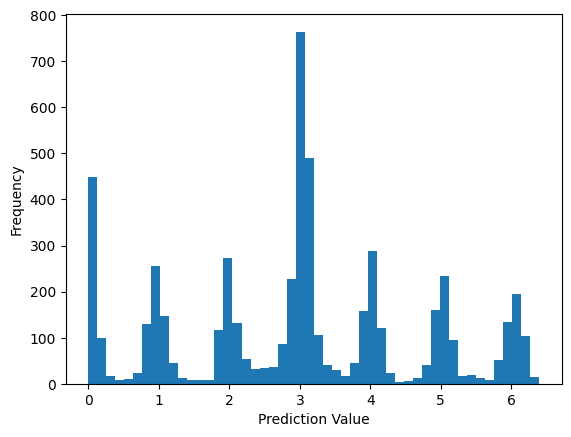

In [103]:
import matplotlib.pyplot as plt

# exclude zero pads
y_pred_first_n = y_pred[:, :n]
y_pred_first_n_rescaled = y_pred_first_n * (q - 1)

plt.hist(y_pred_first_n_rescaled.flatten(), bins=50)
plt.xlabel('Prediction Value')
plt.ylabel('Frequency')
plt.show()

In [104]:
# for layer in model.layers:
#     if layer.trainable_variables:  # Check if the layer has trainable variables
#         for i, var in enumerate(layer.trainable_variables):
#             print(f"{layer.name} - Variable {i} ({var.name}): values: {var.numpy()}")
#     else:
#         print(layer.name, "has no trainable variables.")

In [105]:
# from tensorflow.keras import backend as K
# K.clear_session()